# Data Analysis for Chicago traffic
1. Auto encoder
1. Long Short Term Memory

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM

import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

from sklearn.preprocessing import MinMaxScaler

plt.rcParams['figure.figsize'] = [20, 8]

In [62]:
%bq query -n speed_at_times
SELECT
  _last_updt, current_speed, _region_id
FROM
  `nickapi-184104.demos.regions`
WHERE
  _last_updt > "2018-04-03 12:00:00.000 UTC"

In [63]:
df = speed_at_times.execute().result().to_dataframe()

In [64]:
df.describe()

,current_speed,_region_id
count,11484.000000,11484.000000
mean,21.624283,15.000000
std,7.919826,8.366965
min,0.000000,1.000000
25%,19.090000,8.000000
50%,22.500000,15.000000
75%,26.250000,22.000000
max,173.860000,29.000000


In [65]:
df = df.drop_duplicates()
df = df.pivot(index='_last_updt', columns='_region_id', values='current_speed')
df = df.dropna(how='any')

In [66]:
df.describe()

_region_id,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,...,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
mean,17.862006,24.386977,21.035508,17.983757,20.675621,19.899859,18.920819,19.173531,20.177768,21.091808,...,23.171130,21.175056,25.738531,21.066893,22.401328,24.051469,27.039605,27.072853,20.986638,18.391073
std,7.798023,7.890553,9.487413,6.845986,7.241873,5.417245,6.352158,5.858604,8.255509,3.812888,...,5.701104,7.763014,7.749543,3.161781,5.588795,10.933373,6.044326,8.138148,16.256896,9.012886
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.410000,24.550000,18.410000,17.422500,19.770000,18.107500,17.337500,17.050000,21.140000,19.090000,...,21.820000,19.770000,25.960000,19.770000,20.450000,26.590000,24.550000,27.287500,0.000000,17.730000
50%,19.770000,26.590000,20.450000,19.090000,21.820000,20.450000,19.770000,19.090000,22.500000,20.450000,...,23.860000,23.180000,27.270000,20.450000,23.180000,28.450000,26.590000,28.640000,28.640000,20.450000
75%,21.647500,27.950000,23.255000,21.140000,24.550000,22.500000,22.500000,22.500000,23.860000,23.435000,...,25.230000,25.230000,28.640000,23.180000,25.230000,29.390000,29.320000,30.550000,33.410000,23.180000
max,34.090000,37.400000,173.860000,31.160000,32.450000,30.720000,33.550000,37.500000,34.090000,32.050000,...,43.640000,39.310000,40.400000,27.270000,33.200000,38.320000,54.550000,42.170000,52.740000,39.580000


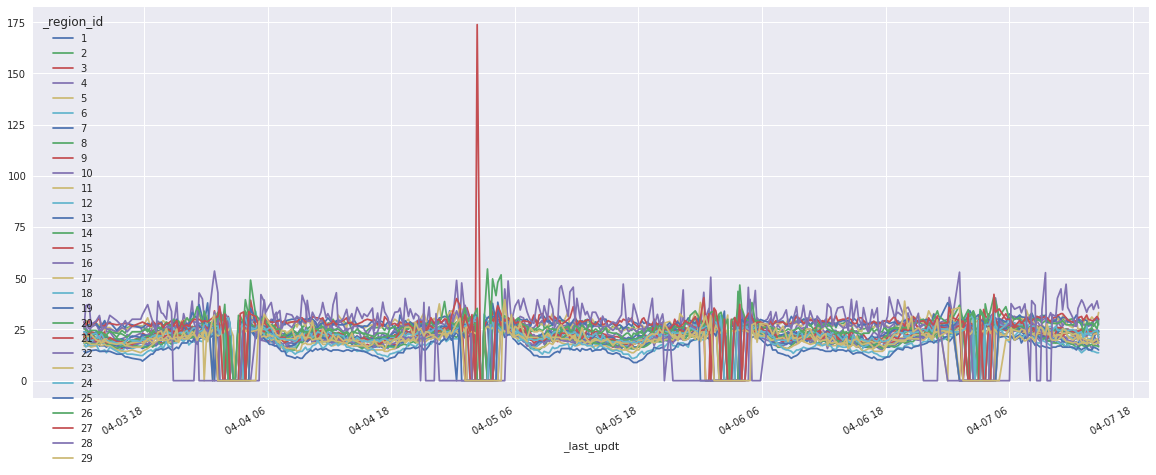

In [67]:
df.plot()

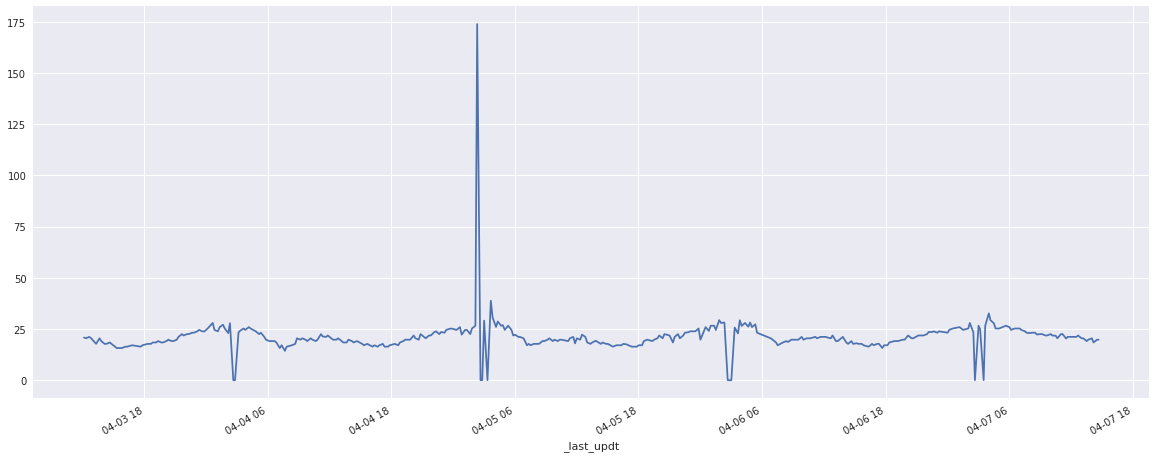

In [68]:
df[3].plot()

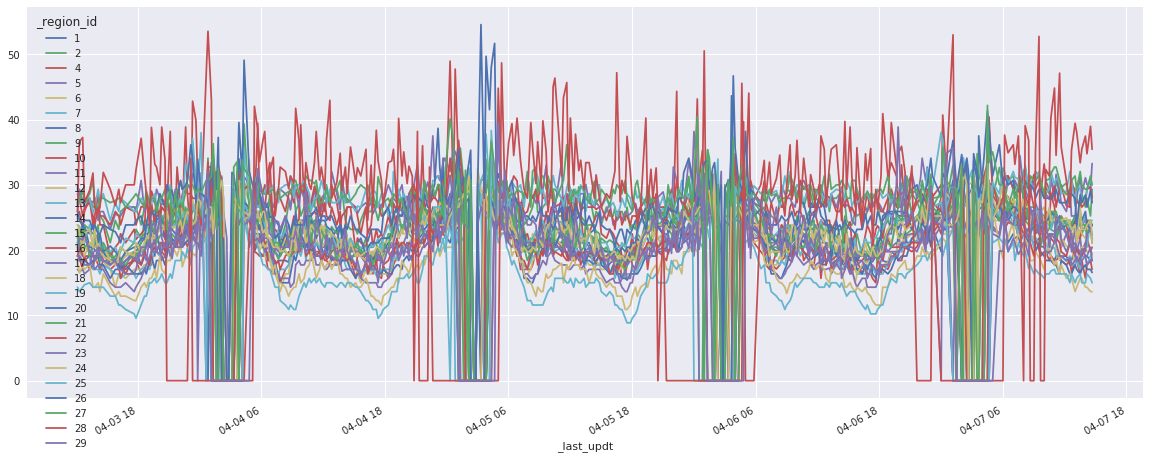

In [69]:
df.drop(3,1).plot()

# Auto Encoder Network
An autoencoder, autoassociator or Diabolo network is an artificial neural network used for unsupervised learning of efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. Recently, the autoencoder concept has become more widely used for learning generative models of data.

![AE](https://cdn-images-1.medium.com/max/800/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

In [70]:
tf.reset_default_graph() 

In [71]:
num_inputs = 29
num_hidden = 2
num_outputs = num_inputs

learning_rate = 0.01

In [72]:
X = tf.placeholder(tf.float32, shape=[None, num_inputs])

In [73]:
hidden = fully_connected(X, num_hidden, activation_fn=None)
outputs = fully_connected(hidden, num_outputs, activation_fn=None)

In [74]:
loss = tf.reduce_mean(tf.square(outputs - X))  # MSE

In [75]:
optimizer = tf.train.AdamOptimizer(learning_rate)
train  = optimizer.minimize( loss)

In [76]:
init = tf.global_variables_initializer()

In [77]:
num_steps = 3000

with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_steps):
        sess.run(train,feed_dict={X: scaled_data})

In [78]:
with tf.Session() as sess:
    sess.run(init)
        
    # Now ask for the hidden layer output (the 2 dimensional output)
    output_2d = hidden.eval(feed_dict={X: scaled_data})

In [79]:
output_2d.shape

(354, 2)

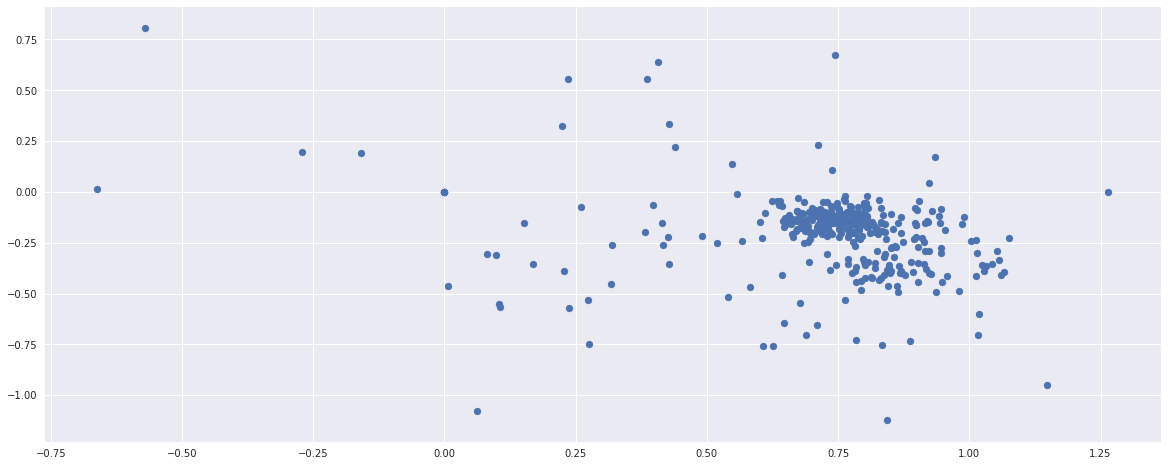

In [80]:
plt.scatter(output_2d[:,0],output_2d[:,1])

# Time Series Forecasting with Sliding Window
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

![LSTM](https://cdn-images-1.medium.com/max/2000/1*Ka6k_WyG9B3gXPlvU0vrOw.png)

### Steps
1. Grab data from bigquery
2. Take speed data and create a global average
3. Format data for ingestion with sliding window
4. Define model
5. Train model
6. Test model

In [33]:
%bq query -n speed_at_times
SELECT
  _last_updt, current_speed, _region_id
FROM
  `nickapi-184104.demos.regions`
WHERE
  _last_updt > "2018-04-03 12:00:00.000 UTC"

In [34]:
df = speed_at_times.execute().result().to_dataframe()

In [35]:
df = df.drop_duplicates()
df = df.pivot(index='_last_updt', columns='_region_id', values='current_speed')
df = df.dropna(how='any')
df.head()

_region_id,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
_last_updt,,,,,,,,,,,,,,,,,,,,,
2018-04-03 12:10:42,19.09,28.50,20.86,19.09,21.14,20.45,19.09,18.41,21.82,19.09,...,20.45,23.18,27.27,18.41,23.86,27.14,25.91,28.64,25.91,19.77
2018-04-03 12:20:58,19.77,28.64,20.45,18.89,19.77,20.45,19.77,18.41,21.68,20.45,...,20.93,20.52,27.95,19.19,23.18,27.27,24.55,27.27,36.58,21.82
2018-04-03 12:40:29,19.77,27.27,21.14,17.05,20.45,20.45,19.09,18.41,22.50,19.09,...,23.86,23.18,25.23,18.41,19.77,27.27,23.86,29.32,37.26,21.55
2018-04-03 12:50:44,18.41,27.14,20.59,19.09,22.50,20.45,19.09,18.41,20.45,19.09,...,23.18,23.18,26.45,17.73,22.50,27.95,24.55,27.27,27.27,22.50
2018-04-03 13:21:04,19.09,27.95,17.73,17.05,19.09,19.77,19.09,17.73,21.14,19.09,...,22.50,19.09,27.27,17.73,23.18,27.95,24.55,28.64,29.18,19.84


In [36]:
df['mean'] = df.mean(axis=1)
df['mean'].to_frame().head(10)

,mean
_last_updt,
2018-04-03 12:10:42,22.011034
2018-04-03 12:20:58,22.463793
2018-04-03 12:40:29,22.131724
2018-04-03 12:50:44,21.943103
2018-04-03 13:21:04,21.780345
2018-04-03 13:40:31,21.338966
2018-04-03 13:50:45,21.207931
2018-04-03 14:10:48,21.282414
2018-04-03 14:21:04,20.569655


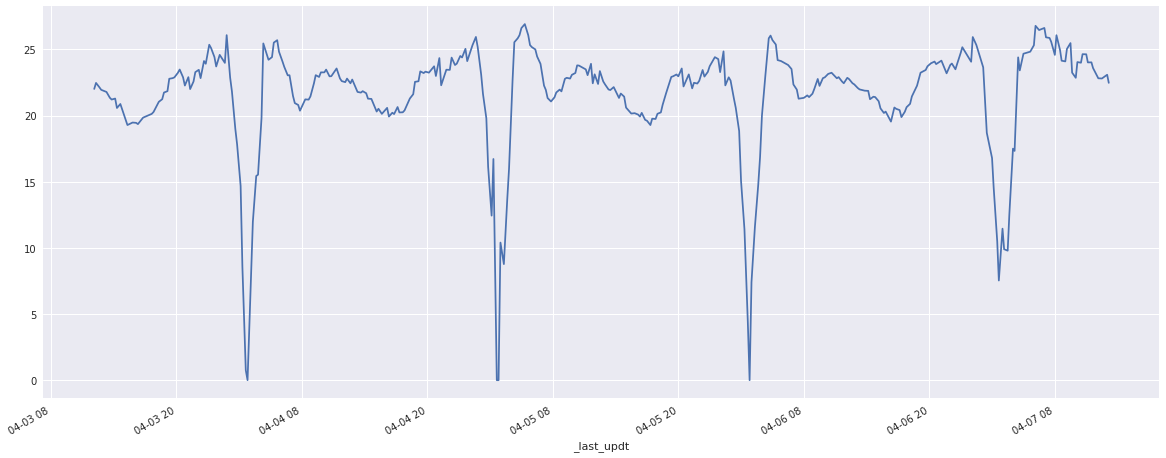

In [37]:
df['mean'].plot()

In [42]:
split_date = '2018-04-06 00:00:00'
train = df.loc[:split_date, ['mean']]
test = df.loc[split_date:, ['mean']]

In [45]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

train_sc.shape

train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
_last_updt,
2018-04-03 12:10:42,0.818002
2018-04-03 12:20:58,0.834828
2018-04-03 12:40:29,0.822488
2018-04-03 12:50:44,0.815478
2018-04-03 13:21:04,0.809429


In [46]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)
    
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
_last_updt,,,,,,,,,,,,
2018-04-03 16:10:58,0.723595,0.716534,0.775662,0.764436,0.790924,0.788156,0.793026,0.809429,0.815478,0.822488,0.834828,0.818002
2018-04-03 16:21:18,0.722698,0.723595,0.716534,0.775662,0.764436,0.790924,0.788156,0.793026,0.809429,0.815478,0.822488,0.834828
2018-04-03 16:51:00,0.719122,0.722698,0.723595,0.716534,0.775662,0.764436,0.790924,0.788156,0.793026,0.809429,0.815478,0.822488
2018-04-03 17:40:43,0.737332,0.719122,0.722698,0.723595,0.716534,0.775662,0.764436,0.790924,0.788156,0.793026,0.809429,0.815478
2018-04-03 17:50:57,0.747943,0.737332,0.719122,0.722698,0.723595,0.716534,0.775662,0.764436,0.790924,0.788156,0.793026,0.809429


In [47]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

X_train_t.shape

(206, 1, 12)

In [54]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 456       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=0)

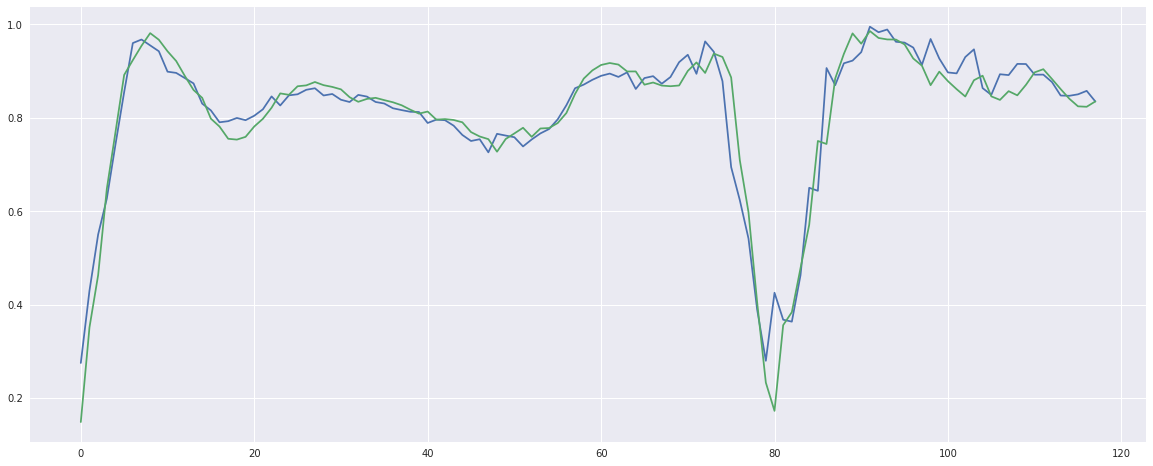

In [57]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

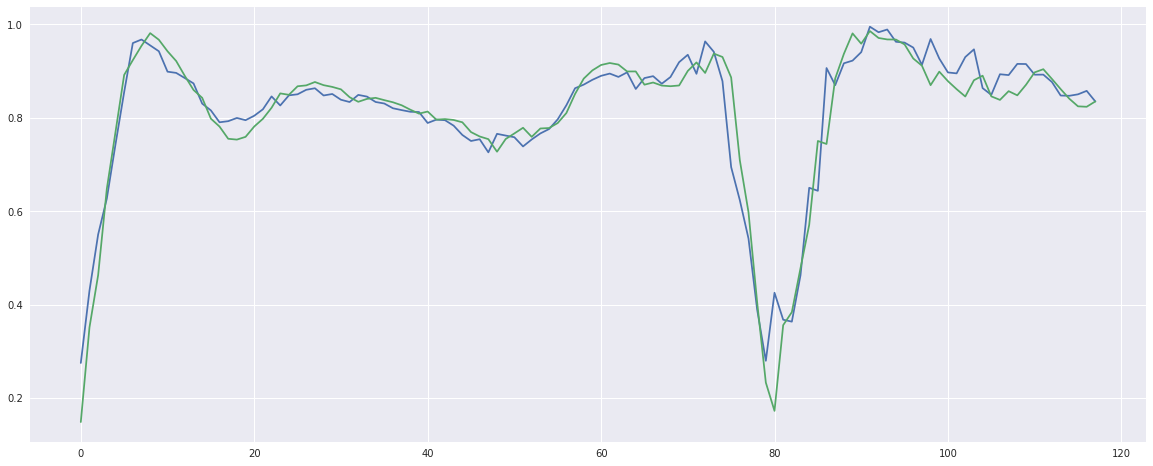

In [58]:
# save model and test if saved sucessfully
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
potato = model_from_json(loaded_model_json)
# load weights into new model
potato.load_weights("model.h5")

y_pred = potato.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)